In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.model_selection import ShuffleSplit

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

#varcluster_info=pd.DataFrame(
#{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
#,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
#,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
#})

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

## 1.1 Word Embedding

In [3]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [4]:
## creating a tagged document
DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])

#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [5]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-02-20 09:36:51.641558 Started
2020-02-20 09:43:26.781145 Completed


In [16]:
## Validating the model response for random words 

modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.61 'community'
    2. 0.59 'biological system'
    3. 0.57 'animal'
    4. 0.56 'bacteria'
    5. 0.56 'insect'
    6. 0.53 'sensory system'
    7. 0.53 'habitat'
    8. 0.52 'natural environment'
    9. 0.51 'olfactory'
    10. 0.51 'model system'
    11. 0.50 'people'
    12. 0.50 'behaviour'
    13. 0.49 'learning'
    14. 0.49 'environmental condition'
    15. 0.48 'efficiently'
    16. 0.48 'locomotion'
    17. 0.48 'environment allow'
    18. 0.48 'primate'
    19. 0.48 'ability'
    20. 0.47 'situation'


## 1.2. PCA

In [19]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 77.46405601501465


In [20]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

SubjectAreaIds=pd.DataFrame(enumerate(merged_data.SubjectArea.unique()),columns=['SubjectAreaId','SubjectArea2'])
finalcols=merged_data.columns.tolist()+['SubjectAreaId']
merged_data=merged_data.merge(SubjectAreaIds, how='left',left_on='SubjectArea',right_on='SubjectArea2')[finalcols]

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

# 2. DBScan

In [36]:
#### Hyper parameter ####
    # eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples -The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
param_dict={'eps':np.linspace(3,4,7) ,'min_samples':[5,15,30,40,45]}

In [37]:
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples or len(list(filter(lambda x:x==-1, cluster_labels.tolist())))<=550:
        return -1
    else:
        score=silhouette_score(X, cluster_labels)
        
    return score

In [33]:

FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']
cat='Engineering Sciences'

CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
clusterer = DBSCAN(eps=3.73, min_samples=10, n_jobs=4)
preds = clusterer.fit_predict(CategoricalDS)

#merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
print('******'+cat+'******')
print(pd.Series(preds).value_counts())
score = silhouette_score(CategoricalDS, preds, metric='euclidean')
print('silhouette score:',score)
print(str(datetime.datetime.now()),'Completed')
print('')

******Engineering Sciences******
 0    8813
-1     563
dtype: int64
silhouette score: 0.5199704149000406
2020-02-15 21:34:45.167518 Completed



2020-02-15 21:36:23.605203 Started
******Natural Sciences******
 0    13051
-1      673
dtype: int64
silhouette score: 0.49735577120832297
2020-02-15 21:39:04.522481 Completed

2020-02-15 21:39:04.522686 Started
******Humanities and Social Sciences******
 0    9415
-1     569
dtype: int64
silhouette score: 0.45409812104100866
2020-02-15 21:40:31.262569 Completed

2020-02-15 21:40:31.262661 Started
******Engineering Sciences******
 0    8793
-1     583
dtype: int64
silhouette score: 0.5129846798746001
2020-02-15 21:41:54.917256 Completed

2020-02-15 21:41:54.917863 Started
******Life Sciences******
 0    17334
-1      615
dtype: int64
silhouette score: 0.6419153201845796
2020-02-15 21:47:01.479227 Completed



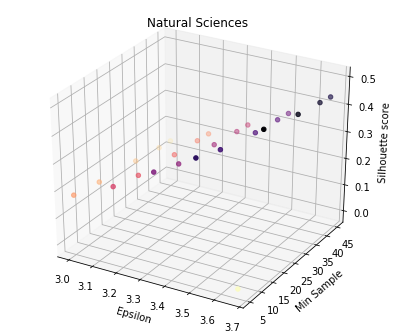

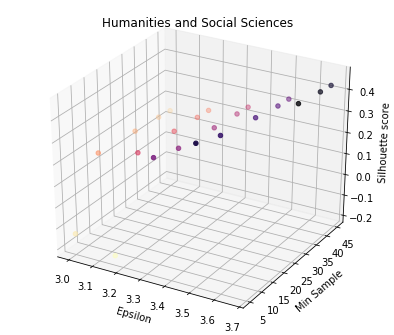

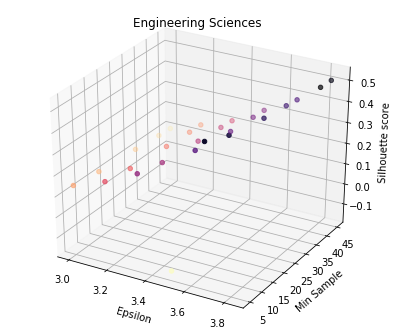

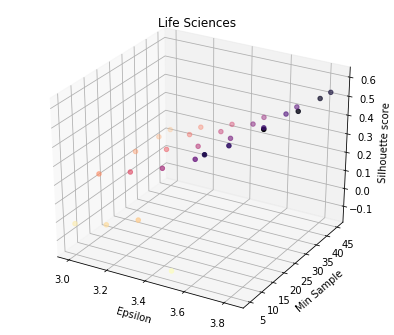

In [38]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

sp=1

FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    
    ## Grid search to select best estimatoe
    gs = GridSearchCV(estimator=DBSCAN(n_jobs=4), param_grid=param_dict, scoring=cv_silhouette_scorer, cv=ShuffleSplit(test_size=.999, n_splits=1, random_state=0), n_jobs=4)
    gs.fit(CategoricalDS)
    result=pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')
    result=result[result['split0_test_score']!=-1]
    
    # Plotting the result
    t = np.arange(len(result))
    fig = plt.figure(figsize=(15,13))
    ax = fig.add_subplot(2,2,sp, projection='3d')
    ax.scatter(result['param_eps'],result['param_min_samples'],result['mean_test_score'],c=t, cmap='magma')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Min Sample')
    ax.set_zlabel('Silhouette score')
    ax.set_title(cat)
    sp=sp+1
    
    clusterer = gs.best_estimator_ #DBSCAN(eps=3.5, min_samples=40, n_jobs=4)
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')


In [40]:
merged_data['DBScanCluster'].value_counts()

 0    48593
-1     2440
Name: DBScanCluster, dtype: int64

In [41]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]

merged_data['CategoryConv']=merged_data.Category.apply(CattoID)

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [42]:
Features=FeatureCols #=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the DBScanCluster result. outlier data are considering as test data to reevaluate.

X_Training_DS=merged_data[Features][merged_data.DBScanCluster==0]
y_Training_DS=merged_data[OP_Feature][merged_data.DBScanCluster==0]

X_Test_DS=merged_data[Features][merged_data.DBScanCluster!=0]
y_Test_DS=merged_data[OP_Feature][merged_data.DBScanCluster!=0]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

## 3.1  k-nearest neighbors 

In [43]:
for k in [4,8,16,25,30]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

neighbors: 4 Accuracy Score : 0.833213293548719
neighbors: 8 Accuracy Score : 0.8532770861199712
neighbors: 16 Accuracy Score : 0.8589361045375039
neighbors: 25 Accuracy Score : 0.8613026031484721
neighbors: 30 Accuracy Score : 0.8618170593682478


neighbors: 25 Accuracy Score : 0.8613026031484721


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.86')

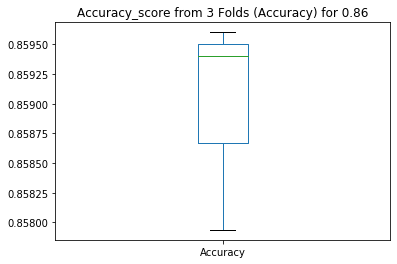

In [44]:
k=30
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)
print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [45]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

[[1295   67  342   52]
 [  30 1708   36   78]
 [ 150   84 2227  154]
 [  51  114  190 3141]]
              precision    recall  f1-score   support

           0      0.849     0.737     0.789      1756
           1      0.866     0.922     0.893      1852
           2      0.797     0.852     0.823      2615
           3      0.917     0.898     0.908      3496

    accuracy                          0.861      9719
   macro avg      0.857     0.852     0.853      9719
weighted avg      0.863     0.861     0.861      9719



## 4. Formatting the output categories based on the predict_proba

In [46]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [47]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''

## 5.1. Random manual result evaluvation 

In [48]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [49]:
fil_1_2=(NewMergedDSAligned['Category_12_Variance']<=.10) & ((NewMergedDSAligned['Category_1']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))
fil_2_3=(NewMergedDSAligned['Category_23_Variance']<=.10) & ((NewMergedDSAligned['Category_3']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))

NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_1']=NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category']
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

In [50]:
NewMergedDSAligned['DBScanCluster'].value_counts()

 0    48593
-1     2440
Name: DBScanCluster, dtype: int64

In [51]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    877
-1    566
Name: DBScanCluster, dtype: int64

In [52]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Engineering Sciences              181
Natural Sciences                  174
Life Sciences                     143
Humanities and Social Sciences     68
Name: Category, dtype: int64

In [58]:
cats='Engineering Sciences'
lim=250
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
14405,Microemulsions are used in bioprocess engineer...,Engineering Sciences,0.439999,0.362277,0.197723,Life Sciences,Natural Sciences,Engineering Sciences,0.077722,0.164554
39318,The BIO-PRICE goal is to address a key challen...,Engineering Sciences,0.439032,0.400056,0.160912,Life Sciences,Natural Sciences,Engineering Sciences,0.038976,0.239145
35825,In the long run night work can contribute to t...,Engineering Sciences,0.435945,0.400624,0.163432,Life Sciences,Humanities and Social Sciences,Natural Sciences,0.035321,0.237192
917,The aim is to develop a system that allows lar...,Engineering Sciences,0.434930,0.325995,0.197781,Life Sciences,Engineering Sciences,Natural Sciences,0.108935,0.128214
39334,The goal of this research proposal is to devel...,Engineering Sciences,0.401691,0.282446,0.158098,Humanities and Social Sciences,Engineering Sciences,Natural Sciences,0.119245,0.124348


In [59]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

['Microemulsions are used in bioprocess engineering, inter alia in the form of inverse micellar two-phase systems for the extraction of biopolymers. For purification of proteins, such systems have already been extensively studied. The behavior of nucleic acids in such systems has so far only been analyzed on a random basis. This is certainly justified by the fact that nucleic acids have not been widely used in comparison to proteins. However, using plasmid DNA as a biopharmaceutical product has changed this situation. Plasmid DNA can be used as a gene carrier for therapeutically relevant genes in gene therapy or as a vehicle for encoded antigens in the genetic vaccine. Compared to conventional therapeutics or vaccines, such plasmid-based drugs are less risky and easier to produce. Within the scope of the research project inversmicellular biphasic systems will be investigated, which allow a selective purification of the plasmid DNA. Conditions influencing the distribution should be dete

In [295]:
#NewMergedDSAligned.to_csv(Path+'WEPCADBScanFindingsKMeans.csv', index=False)

## 5.2. Each category TF/IDF based result evaluvation 

In [60]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [61]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [62]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [101]:
input_data.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription', 'File_Categories', 'Category',
       'DBScanCluster', 'Category_1_Values', 'Category_2_Values',
       'Category_3_Values', 'Category_1', 'Category_2', 'Category_3',
       'Category_12_Variance', 'Category_23_Variance', 'CategoryCollc'],
      dtype='object')

In [102]:
sizes=len(input_data.CategoryCollc.unique())
category_tfidfs=pd.DataFrame()

with tqdm(total=len(input_data['CategoryCollc'].unique())) as bar:
    for i,bucket in input_data.groupby(['CategoryCollc']):
        varcat=pd.DataFrame()

        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[[0,'Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        varcat['bucket_length']=len(bucket)
        varcat['bucket_category']=bucket['Category'].unique()[0]
        varcat['Category_1']=bucket['Category_1'].unique()[0]
        varcat['Category_2']=bucket['Category_2'].unique()[0]
        varcat['Category_3']=bucket['Category_3'].unique()[0]

        varcat['Category_1_Score']=bucket['Category_1_Values'].mean()
        varcat['Category_2_Score']=bucket['Category_2_Values'].mean()
        varcat['Category_3_Score']=bucket['Category_3_Values'].mean()

        varcat=varcat.reset_index()

        category_tfidfs=pd.concat([varcat[varcat.columns[1:]],category_tfidfs])
        bar.update(1)

In [106]:
cats='Engineering Sciences'
cat1='Humanities and Social Sciences'
cat2='Life Sciences'
cat3=''  #'Natural Sciences'
 
lim=200
#NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

In [107]:
#NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()

In [105]:
category_tfidfs.to_csv(Path+'CategoryTFIDFSummary_WEPCADBScanFindingsKMeansV2_Exp1.2.0.csv', index=False)

# Visualization

In [108]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=0)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

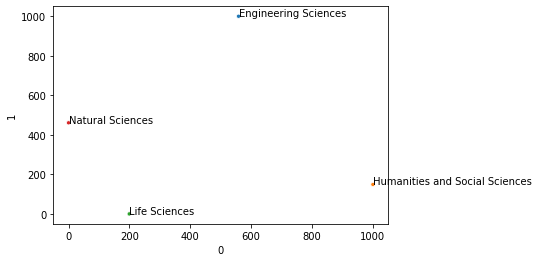

In [111]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

#coords = TSNE(n_components=2,perplexity=1.9, random_state=7, metric='precomputed').fit_transform(sym_dist)
coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [110]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.564064,0.653382,0.418961
Humanities and Social Sciences,0.564064,0.000000,0.471592,0.725817
Life Sciences,0.653382,0.471592,0.000000,0.223400
Natural Sciences,0.418961,0.725817,0.223400,0.000000


In [112]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,199.413519,0.000000,-24.948981,423.776019,-134.617500,134.617500
1,Natural Sciences,171.5500,0.000000,460.894053,-171.550000,171.550000,357.964053,563.824053
2,Humanities and Social Sciences,124.8000,1000.000000,148.947396,875.200000,1124.800000,74.067396,223.827396
3,Engineering Sciences,117.2000,558.572156,1000.000000,441.372156,675.772156,929.680000,1070.320000


In [113]:
pca.shape

(51033, 20)

In [114]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-02-15 22:37:15.867899 Started for Engineering Sciences
2020-02-15 22:37:46.782968 Completed for Engineering Sciences
2020-02-15 22:37:46.783191 Started for Humanities and Social Sciences
2020-02-15 22:38:20.361313 Completed for Humanities and Social Sciences
2020-02-15 22:38:20.361706 Started for Life Sciences
2020-02-15 22:39:23.987030 Completed for Life Sciences
2020-02-15 22:39:23.987216 Started for Natural Sciences
2020-02-15 22:40:17.508740 Completed for Natural Sciences


In [115]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


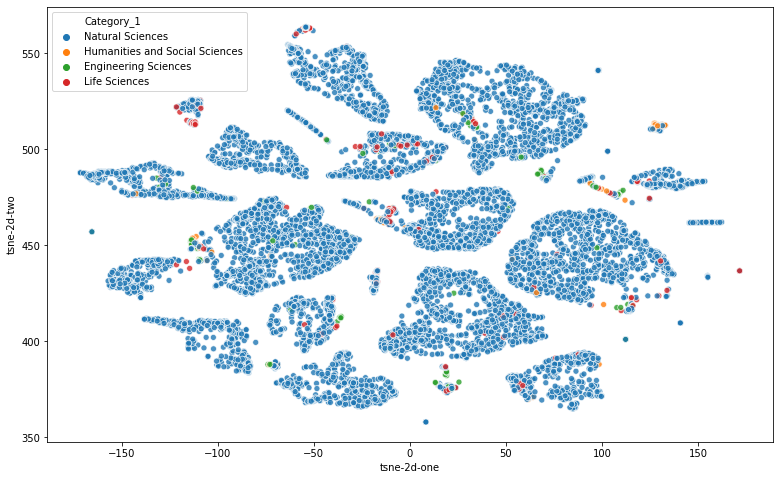

In [120]:
cat='Natural Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'Engineering Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

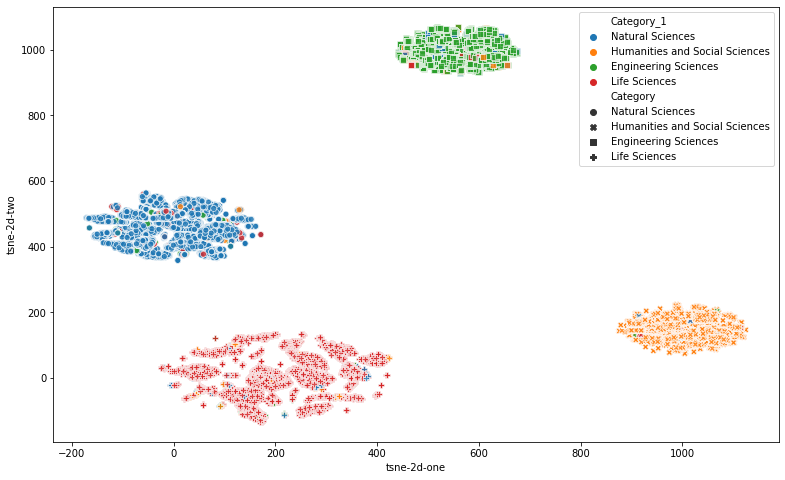

In [117]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [121]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.DBScanCluster==0)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','DBScanCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['DBScanCluster']!=0),'interdiscipilinary']=True

In [122]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [123]:
Report_extrat.to_csv(Path+'Report_WEPCADBScanFindingsKMeansV2_Exp1.2.0.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCADBScanFindingsKMeansV2_Exp1.2.0.csv', index=False)